In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.distributions.beta import Beta
from torch.nn.utils import weight_norm
from torchaudio.transforms import MelSpectrogram, MFCC
import torchaudio
import numpy as np
import pandas as pd
import random
import pickle
import time
import base64
from sklearn.metrics import average_precision_score, recall_score, classification_report, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import re

In [ ]:
#### Edit variables and filepaths here ####
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
SEED = 42
torch.manual_seed(SEED)
EMBEDDINGS = 'hubert_embeddings'
LOAD_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/baseline-vad/model.pth')

SMALL_CAPACITY = False
EMB_SIZE = 'base' # 'base' 768 embeddings or 'large' 1024 embeddings

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cuda


In [ ]:
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

test_csv_file = f'./drive/MyDrive/Thesis/{EMB_SIZE}/{DATASET_SEED}/processed/test_dataset.csv'

selected_columns = ['audio_file_name', 'classification', EMBEDDINGS]

test_df = pd.read_csv(test_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})

In [ ]:
def print_dataset_balance(df):
    classification_counts = df['classification'].value_counts().reset_index()
    # Rename the columns for clarity
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

In [ ]:
print_dataset_balance(test_df)

   classification  count  percentage
0               1    284        74.3
1               0     98        25.7


In [ ]:
class AudioEmbeddingsDataset(Dataset):
    def __init__(self, audio_file_name, labels):
        self.labels = labels
        self.file_names = audio_file_name

        # Precompute and store all MFCC features
        self.audio_features = [self.extract_mfcc(os.path.join('./drive/MyDrive/Thesis/audio', fname)) for fname in audio_file_name]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.labels[idx], self.file_names[idx], self.audio_features[idx]

    def extract_mfcc(self, audio_path):
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc_transform = MFCC(
            sample_rate=sample_rate,
            n_mfcc=13,
            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False},
        )
        mfcc = mfcc_transform(waveform).squeeze().transpose(0, 1)
        return mfcc

def collate_fn(batch):
    labels, file_names, features = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert stereo to mono by averaging across the channel dimension
    features = [feature.mean(1) for feature in features]
    lengths = [feature.shape[1] for feature in features]  # Updated index for time dimension

    # Transpose such that time dimension is first
    features = [feature.transpose(0, 1) for feature in features]
    features = pad_sequence(features, batch_first=True)

    return features, file_names, labels, lengths

test_labels = test_df['classification']
test_file_names = test_df['audio_file_name']

test_dataset = AudioEmbeddingsDataset(test_file_names, test_labels)

In [ ]:
BATCH_SIZE = 1 # to allow for analysis of results

# Change below for data augmentation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [ ]:
# LSTM Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout_rate if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, embedding, lengths):
        packed = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [ ]:
# make these auto-fill parameters in the model
INPUT_DIMENSION = 13
NUM_HIDDEN_UNITS = 64
OUTPUT_DIMENSION = 1
NUM_LSTM_LAYERS = 1
BI_DIRECTIONAL = True
DROPOUT_RATE = 0

model = Classifier(INPUT_DIMENSION, NUM_HIDDEN_UNITS, OUTPUT_DIMENSION, NUM_LSTM_LAYERS, BI_DIRECTIONAL, DROPOUT_RATE).to(device)
model.load_state_dict(torch.load(LOAD_WEIGHTS_PATH))
print('Loaded model in')
model.eval()  # set the model to evaluation mode

Loaded model in


Classifier(
  (rnn): LSTM(13, 64, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [ ]:
TRUE_THRESHOLD = 0.5

y_name = []
y_true = []
y_score = []
y_assigned = []
latencies = []

def test(model, iterator):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for audio_features, file_names, labels, lengths in iterator:
            audio_features, labels = audio_features.to(device), labels.to(device)
            start_time = time.time()
            output = model(audio_features, lengths).squeeze(1)
            pred = torch.sigmoid(output)
            rounded_pred = torch.where(pred >= TRUE_THRESHOLD, torch.tensor(1, device=pred.device), torch.tensor(0, device=pred.device))
            end_time = time.time()

            latency = end_time - start_time
            latencies.append(latency)

            y_true.append(float(labels[0]))
            y_score.append(float(pred[0]))
            y_assigned.append(float(rounded_pred[0]))
            y_name.append(file_names[0])

test(model, test_loader)

In [ ]:
print(classification_report(y_true, y_assigned, target_names=['non-interruption', 'interruption']))

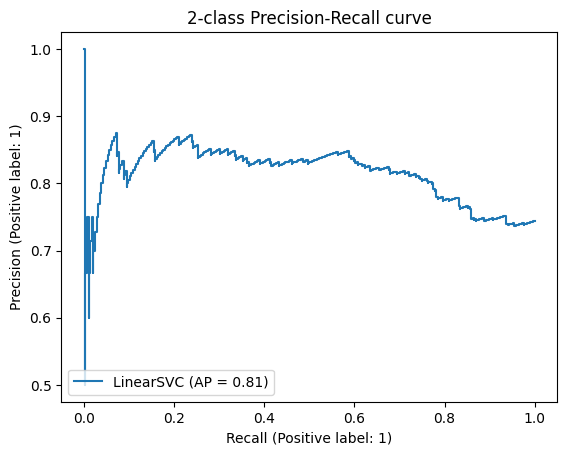

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_true, y_score, name="LinearSVC"
)

_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [ ]:
mean_latency = sum(latencies) / len(latencies)
print(f"Mean Latency: {mean_latency:.3f} seconds")

Mean Latency: 0.014 seconds
